In [10]:
import warnings

from typing import List

warnings.filterwarnings("ignore")

In [11]:
# Dejar el path principal como el anterior.
import sys

sys.path.append('../')

In [12]:
import logging

# Crear el logger
log = logging.getLogger(__name__)

# Setear el nivel del registro
log.setLevel(logging.DEBUG)

# Formato de los mensajes
formatter = logging.Formatter("%(levelname)s: (%(asctime)s) [%(filename)s: %(lineno)s] %(message)s")

if not log.hasHandlers():
    # Handlers
    file_handler = logging.FileHandler("logging.log")
    file_handler.setFormatter(formatter)  # Setear el formato del handler
    # Agregar el handler al logger
    # log.addHandler(file_handler)

    stream_handler = logging.StreamHandler()
    stream_handler.setFormatter(formatter)
    # Agregar el handler al logger
    log.addHandler(stream_handler)

Instalar la librería plot-likert y otras librerías útiles

In [13]:
# Librería para hacer gráficos Likert
# !pip install plot-likert

# Para obtener datos de excel
# !pip install openpyxl

# Para tener un transformador de data
# !pip install -U scikit-learn

# Para tener herramientas estadísticas
# !python -m pip install statsmodels

# Para tener Seaborn
# !pip install seaborn

Empezamos importando la librería para verificar que estuvo bien instalada.

In [14]:
import plot_likert

Importamos algunas librerías útiles para el resto del notebook

In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

In [16]:
DATA_PATH = Path(r"..\data")

if not DATA_PATH.exists():
    log.info(f"Creando carpeta {DATA_PATH = }")
    DATA_PATH.mkdir()

In [17]:
QNA_COMPLETE_PATH = DATA_PATH / "questions-and-answers-complete.xlsx"
QNA_COMPLETE_PATH

WindowsPath('../data/questions-and-answers-complete.xlsx')

In [21]:
log.debug(f"Importando datos de {QNA_COMPLETE_PATH}")
df = pd.read_excel(QNA_COMPLETE_PATH)

log.debug(f"Cantidad de respuestas: {len(df) = }")

columnas = list(df.columns)
preguntas = columnas[1:]
notas = columnas[0]

df.head()

DEBUG: (2022-12-25 20:09:37,640) [1290852740.py: 1] Importando datos de ..\data\questions-and-answers-complete.xlsx
DEBUG: (2022-12-25 20:09:37,708) [1290852740.py: 4] Cantidad de respuestas: len(df) = 86


,Prom Cs,¿Los profesores de ciencias consideran los intereses de los alumnos para elaborar y organizar las evaluaciones?,De las actividades realizadas en clase ¿el profesor considera y respeta nuestros intereses?,¿El profesor retroalimenta y refuerza en todas las clases lo que hemos ido aprendiendo?,El profesor de la clase de ciencias ¿anota y explica el objetivo que se va a trabajar durante la clase?,"El profesor, al cierre de su clase ¿realiza preguntas para verificar si hemos aprendido?",Cuando el profesor da tareas ¿las explica claramente y nos da ejemplos que orientan para realizarlas?,Durante la actividad ¿el profesor circula explicando y resolviendo dudas?,"¿Se realizan salidas a terreno: museos, zoológicos y otros lugares que ayudan al aprendizaje?","Para hacer las clases, el profesor ¿nos lleva a otros espacios motivantes para que aprendamos mejor?",...,"Cuando me queda alguna duda de la clase, ¿me dirijo confiadamente al profesor a preguntar?","Cuando el profesor es cercano conmigo y mis compañeros, ¿nos da confianza y seguridad para preguntar todas las dudas?",Cuando tengo más cercanía y confianza con el profesor ¿aprendo mejor?,"¿Los profesores de ciencias ofrecen diversas actividades grupales de un mismo tema, para que los estudiantes, elijan en la que quieren trabajar?",¿Los profesores de ciencias integran a todos los estudiantes para que participen en las actividades grupales dentro de la sala de clases?,"¿Los profesores de ciencias integran a todos los estudiantes en grupos, para que participen en las actividades de investigación, fuera del colegio?","¿Los profesores, muestran interés por reforzar a los alumnos que más les cuesta?","Cuando el profesor nos hace realizar actividades variadas, en ciencias ¿comprendo mejor la materia?",¿Los profesores de ciencias integran a todos los estudiantes para que participen en las actividades prácticas de laboratorio?,"En las clases de ciencias, ¿algunos alumnos son evaluados con carpetas de actividades realizadas en el colegio y fuera de él?"
0,6.8,Ocasionalmente,Casi siempre,"Siempre, en todas las clases","Siempre, en todas las clases","Siempre, en todas las clases",Casi siempre,"Siempre, en todas las clases",Nunca,Rara vez,...,Casi siempre,"Siempre, en todas las clases","Siempre, en todas las clases",Casi siempre,Casi siempre,Rara vez,Casi siempre,"Siempre, en todas las clases","Siempre, en todas las clases",Nunca
1,6.7,"Siempre, en todas las clases","Siempre, en todas las clases","Siempre, en todas las clases","Siempre, en todas las clases",Casi siempre,"Siempre, en todas las clases","Siempre, en todas las clases","Siempre, en todas las clases","Siempre, en todas las clases",...,"Siempre, en todas las clases","Siempre, en todas las clases","Siempre, en todas las clases","Siempre, en todas las clases","Siempre, en todas las clases","Siempre, en todas las clases","Siempre, en todas las clases","Siempre, en todas las clases","Siempre, en todas las clases","Siempre, en todas las clases"
2,6.1,"Siempre, en todas las clases","Siempre, en todas las clases","Siempre, en todas las clases","Siempre, en todas las clases",Ocasionalmente,"Siempre, en todas las clases","Siempre, en todas las clases",Nunca,Ocasionalmente,...,"Siempre, en todas las clases","Siempre, en todas las clases","Siempre, en todas las clases","Siempre, en todas las clases","Siempre, en todas las clases",Nunca,"Siempre, en todas las clases","Siempre, en todas las clases","Siempre, en todas las clases",Ocasionalmente
3,4.6,Casi siempre,Casi siempre,Rara vez,Casi siempre,Casi siempre,Casi siempre,Ocasionalmente,Nunca,Ocasionalmente,...,Nunca,Casi siempre,"Siempre, en todas las clases",Ocasionalmente,Casi siempre,"Siempre, en todas las clases",Rara vez,Ocasionalmente,Rara vez,Nunca
4,6.5,"Siempre, en todas las clases","Siempre, en todas las clases","Siempre, en todas las clases","Siempre, en todas las clases","Siempre, en todas las clases","Siempre, en todas las clases",Casi siempre,Nunca,Ocasionalmente,...,"Siempr

Buscaremos la correlación entre variables numéricas y categóricas utilizando ANOVA. Este propone como hipótesis nula lo siguiente:
\begin{equation}
H_0:\ \text{Las variables{\bf NO} están correlacionadas. (es decir, el promedio de todos los grupos{\bf son el mismo})}
\end{equation}

Este método nos arrojará un $p$-valor, el cual interpretamos de la siguiente forma: si el $p$-valor es mayor a $0.05$, entonces aceptamos la hipótesis nula $H_0$ y "concluimos" que las variables **NO** están correlacionadas.

Con las siguientes líneas de código podremos ver la correlación entre dos variables.

In [121]:
from scipy.stats import f_oneway


def anova_corr(df, cat_name, num_name):
    # Agrupamos la variable categórica con una lista de sus respectivos valores numéricos
    category_group_lists = df.groupby(cat_name)[num_name].apply(list)
    # Aplicamos la función f_oneway para calcular los estadísticos
    anova_results = f_oneway(*category_group_lists)
    # Retornamos
    return anova_results


anova_corr(df, preguntas[0], notas)

F_onewayResult(statistic=1.8616659866452063, pvalue=0.12516073963870358)

Empezamos a calcular la matriz de correlaciones

In [78]:
corr_cat_num = pd.DataFrame()

for i in range(len(preguntas)):
    corr_cat_num.loc["Notas", f"Pregunta {i+1:02d}"] = anova_corr(df, preguntas[i], notas)[1]

corr_cat_num

,Pregunta 01,Pregunta 02,Pregunta 03,Pregunta 04,Pregunta 05,Pregunta 06,Pregunta 07,Pregunta 08,Pregunta 09,Pregunta 10,...,Pregunta 22,Pregunta 23,Pregunta 24,Pregunta 25,Pregunta 26,Pregunta 27,Pregunta 28,Pregunta 29,Pregunta 30,Pregunta 31
Notas,0.125161,0.670056,0.282572,0.008347,0.281641,0.361459,0.145925,0.036974,0.123656,0.266122,...,0.005718,0.077819,0.491269,0.32601,0.08855,0.924846,0.039253,0.11277,0.037206,0.157585


In [93]:
# Crear la carpeta de imágenes, si no se ha creado
from pathlib import Path


IMG_PATH = Path(r"..\img")

if not IMG_PATH.exists():
    log.info(f"Creando path {IMG_PATH = }")
    IMG_PATH.mkdir()

In [94]:
# Crear la carpeta de correlaciones, si no se ha creado
IMG_CORR_PATH = IMG_PATH / "correlations"

if not IMG_CORR_PATH.exists():
    log.info(f"Creando path {IMG_CORR_PATH = }")
    IMG_CORR_PATH.mkdir()

INFO: (2022-12-25 21:01:36,852) [3310910967.py: 5] Creando path IMG_CORR_PATH = WindowsPath('../img/correlations')


DEBUG: (2022-12-26 19:41:52,837) [892675699.py: 23] save_config={'dpi': 600, 'bbox_inches': 'tight'}


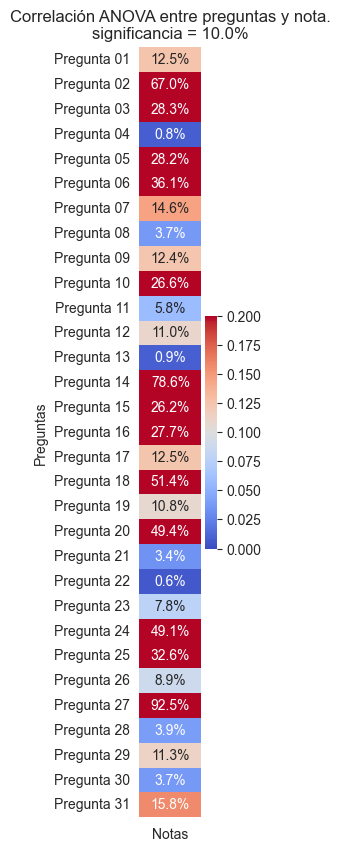

In [125]:
significancia = 0.1

fig, ax = plt.subplots(figsize=(1, 10))


sns.heatmap(
    corr_cat_num.T,
    vmin=0, vmax=significancia * 2,
    center=significancia,
    cmap="coolwarm",
    annot=True,
    # square=True,
    fmt=".1%"
)

plt.title(f"Correlación ANOVA entre preguntas y nota.\nsignificancia = {significancia:.1%}")

plt.ylabel("Preguntas")

save_config = dict()
save_config.setdefault("dpi", 600)
save_config.setdefault("bbox_inches", "tight")
log.debug(f"{save_config=}")
fig.savefig(IMG_CORR_PATH / "corr-pregunta-nota.png", **save_config)

plt.show()

La significancia es el grado de "libertad" en que uno puede rechazar una hipótesis nula. Si uno tiene una significancia mayor, será más permisivo en rechazar hipótesis nulas, de forma que más veces se concluirá que dos variables estarán correlacionadas. Las significancias que típicamente se utilizan son los de $10\%$, $5\%$, $2.5\%$, $1\%$ e incluso $0.1\%$

Un valor alto de $p$-valor se puede interpretar como que la pregunta no aporta información para la nota.

El valor de la escala va desde el cero hasta dos veces la significancia. Esto se hace así, porque valores más alto a dos veces la significancia, se pueden interpretar como *outliers*, y sólo afectan en la escala de colores, haciendo más difícil leerles. Es para mayor robustez.

Los colores naranjas son valores en los que **ya se aceptó** la hipótesis nula, es decir, que se concluye que las variables **no** están correlacionadas, sin embargo, se puede deber a que falta mayor información, y que siendo un poco más laxos, se puede aceptar aquella correlación como válida.

Para ver las correlaciones entre variables categóricas será necesario utilizar el test del Chi-Cuadrado.

In [96]:
cross_tab_result = pd.crosstab(index=df[preguntas[0]], columns=df[preguntas[1]])
cross_tab_result

De las actividades realizadas en clase ¿el profesor considera y respeta nuestros intereses?,Casi siempre,Ocasionalmente,Rara vez,"Siempre, en todas las clases"
¿Los profesores de ciencias consideran los intereses de los alumnos para elaborar y organizar las evaluaciones?,,,,
Casi siempre,14,6,2,10
Nunca,0,3,0,0
Ocasionalmente,14,5,1,4
Rara vez,2,2,3,0
"Siempre, en todas las clases",2,1,0,17


In [98]:
from scipy.stats import chi2_contingency

chi_sqr_result = chi2_contingency(cross_tab_result)
chi_sqr_result

(55.18639512928828,
 1.6758513103751255e-07,
 12,
 array([[11.90697674,  6.3255814 ,  2.23255814, 11.53488372],
        [ 1.11627907,  0.59302326,  0.20930233,  1.08139535],
        [ 8.93023256,  4.74418605,  1.6744186 ,  8.65116279],
        [ 2.60465116,  1.38372093,  0.48837209,  2.52325581],
        [ 7.44186047,  3.95348837,  1.39534884,  7.20930233]]))

In [101]:
def chi_sqr_corr(df, cat_name1, cat_name2):
    cross_tab_result = pd.crosstab(index=df[cat_name1], columns=df[cat_name2])
    chi_sqr_result = chi2_contingency(cross_tab_result)
    return chi_sqr_result

chi_sqr_corr(df, preguntas[0], preguntas[0])

(343.9999999999999,
 1.8431129097756374e-63,
 16,
 array([[11.90697674,  1.11627907,  8.93023256,  2.60465116,  7.44186047],
        [ 1.11627907,  0.10465116,  0.8372093 ,  0.24418605,  0.69767442],
        [ 8.93023256,  0.8372093 ,  6.69767442,  1.95348837,  5.58139535],
        [ 2.60465116,  0.24418605,  1.95348837,  0.56976744,  1.62790698],
        [ 7.44186047,  0.69767442,  5.58139535,  1.62790698,  4.65116279]]))

In [109]:
from itertools import product

chi_sqr_mat = pd.DataFrame()

for i, j in product(range(len(preguntas)), repeat=2):
    log.debug(f"Voy en la pregunta\n{i = },\n{j = }.")
    chi_sqr_mat.loc[f"P{i+1:02d}", f"P{j+1:02d}"] = chi_sqr_corr(df, preguntas[i], preguntas[j])[1]

chi_sqr_mat

DEBUG: (2022-12-26 18:30:46,541) [3946711725.py: 6] Voy en la pregunta
i = 0,
j = 0.
DEBUG: (2022-12-26 18:30:46,573) [3946711725.py: 6] Voy en la pregunta
i = 0,
j = 1.
DEBUG: (2022-12-26 18:30:46,603) [3946711725.py: 6] Voy en la pregunta
i = 0,
j = 2.
DEBUG: (2022-12-26 18:30:46,629) [3946711725.py: 6] Voy en la pregunta
i = 0,
j = 3.
DEBUG: (2022-12-26 18:30:46,660) [3946711725.py: 6] Voy en la pregunta
i = 0,
j = 4.
DEBUG: (2022-12-26 18:30:46,692) [3946711725.py: 6] Voy en la pregunta
i = 0,
j = 5.
DEBUG: (2022-12-26 18:30:46,722) [3946711725.py: 6] Voy en la pregunta
i = 0,
j = 6.
DEBUG: (2022-12-26 18:30:46,750) [3946711725.py: 6] Voy en la pregunta
i = 0,
j = 7.
DEBUG: (2022-12-26 18:30:46,779) [3946711725.py: 6] Voy en la pregunta
i = 0,
j = 8.
DEBUG: (2022-12-26 18:30:46,803) [3946711725.py: 6] Voy en la pregunta
i = 0,
j = 9.
DEBUG: (2022-12-26 18:30:46,830) [3946711725.py: 6] Voy en la pregunta
i = 0,
j = 10.
DEBUG: (2022-12-26 18:30:46,864) [3946711725.py: 6] Voy en la pr

,P01,P02,P03,P04,P05,P06,P07,P08,P09,P10,...,P22,P23,P24,P25,P26,P27,P28,P29,P30,P31
P01,1.843113e-63,1.675851e-07,1.652192e-01,1.067918e-02,1.389956e-04,2.864733e-04,5.042231e-02,8.570423e-01,7.589770e-01,1.934477e-04,...,1.261591e-03,5.360300e-01,2.775159e-01,4.107038e-03,1.871915e-01,1.809976e-01,6.845397e-03,4.126036e-03,2.071207e-03,7.097662e-02
P02,1.675851e-07,2.038368e-50,1.428780e-03,1.298646e-01,4.712549e-02,3.057145e-05,7.489843e-02,7.154744e-01,9.450010e-01,3.103483e-04,...,5.741777e-02,1.170437e-01,5.479351e-02,2.792161e-01,2.084378e-01,2.192370e-01,4.610073e-03,2.344129e-03,7.036357e-02,6.323928e-01
P03,1.652192e-01,1.428780e-03,1.843113e-63,2.646197e-03,2.442468e-02,1.609983e-09,1.004916e-15,9.157396e-01,4.145202e-01,8.221442e-06,...,9.688927e-04,7.085282e-09,7.232311e-13,4.324551e-03,1.303399e-18,1.989881e-02,5.771637e-19,3.583521e-05,5.380299e-04,4.927473e-01
P04,1.067918e-02,1.298646e-01,2.646197e-03,2.038368e-50,9.251242e-02,5.649685e-03,3.293614e-03,3.818040e-01,9.488658e-01,6.457719e-03,...,3.095629e-06,2.559513e-04,4.206419e-01,3.046937e-01,4.197151e-01,7.852992e-01,9.136348e-03,4.694751e-01,4.996184e-02,4.399185e-01
P05,1.389956e-04,4.712549e-02,2.442468e-02,9.251242e-02,1.843113e-63,6.880864e-02,4.027677e-02,9.735188e-01,9.344101e-01,1.953529e-02,...,2.489636e-02,9.179520e-03,1.027258e-02,1.275651e-01,4.157524e-02,6.299919e-01,4.476039e-02,9.105981e-05,9.042779e-02,9.990977e-01
P06,2.864733e-04,3.057145e-05,1.609983e-09,5.649685e-03,6.880864e-02,1.843113e-63,9.181556e-12,8.588629e-01,7.867355e-01,4.675613e-04,...,1.947998e-04,1.073720e-07,2.009874e-05,5.520594e-01,2.175710e-06,3.478545e-04,4.054825e-11,5.735018e-07,3.152724e-03,6.918432e-01
P07,5.042231e-02,7.489843e-02,1.004916e-15,3.293614e-03,4.027677e-02,9.181556e-12,1.843113e-63,9.789274e-01,7.988132e-01,5.215782e-07,...,3.141276e-07,4.109257e-13,7.534636e-08,1.129847e-03,4.809085e-16,5.718270e-02,9.944354e-20,1.863850e-05,3.486577e-03,6.762639e-01
P08,8.570423e-01,7.154744e-01,9.157396e-01,3.818040e-01,9.735188e-01,8.588629e-01,9.789274e-01,1.843113e-63,1.623335e-12,8.705322e-01,...,2.727917e-01,4.471014e-01,8.653653e-01,5.723052e-01,7.868779e-01,2.271857e-03,9.247525e-01,9.098102e-01,1.364222e-01,1.669472e-09
P09,7.589770e-01,9.450010e-01,4.145202e-01,9.488658e-01,9.344101e-01,7.867355e-01,7.988132e-01,1.623335e-12,1.843113e-63,4.107374e-01,...,4.297469e-01,6.320219e-01,1.463585e-01,4.099665e-01,6.651720e-01,1.094936e-03,6.622441e-01,7.664747e-01,4.603581e-03,8.246529e-11
P10,1.934477e-04,3.103483e-04,8.221442e-06,6.457719e-03,1.953529e-02,4.675613e-04,5.215782e-07,8.705322e-01,4.107374e-01,1.843113e-63,...,1.810253e-05,2.674394e-04,1.180762e-06,9.780819e-05,1.096294e-06,1.604054e-01,6.552063e-07,4.297643e-07,3.718442e-03,4.136912e-01


DEBUG: (2022-12-26 18:50:07,851) [576439454.py: 26] save_config={'dpi': 600, 'bbox_inches': 'tight'}


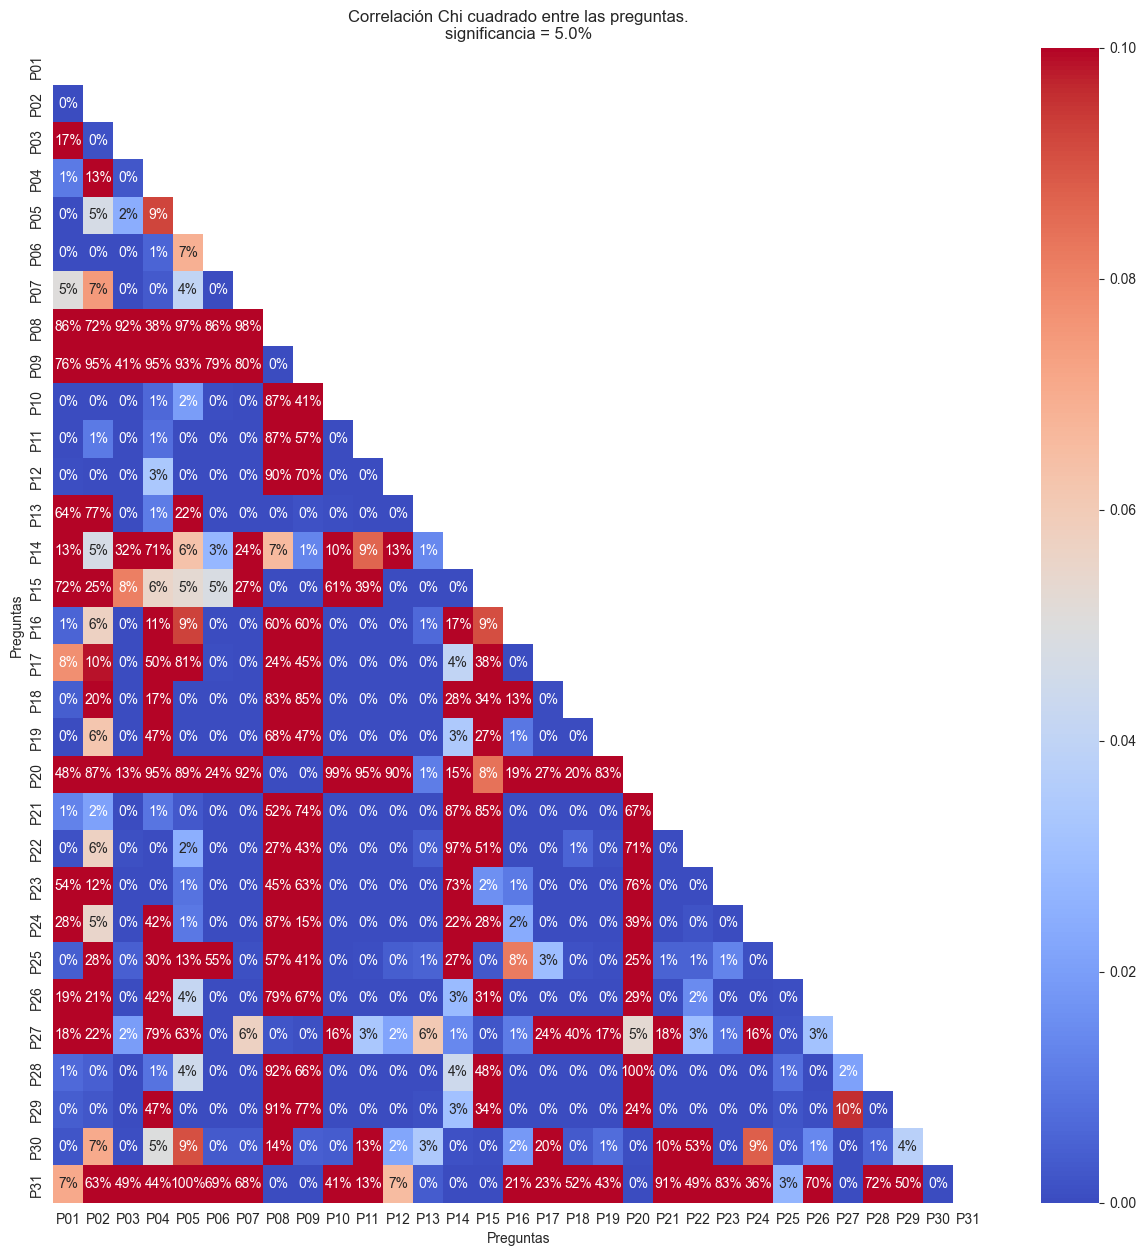

In [120]:
significancia = 0.05

fig, ax = plt.subplots(figsize=(15, 15))

mask = np.triu(np.ones_like(chi_sqr_mat, dtype=np.bool))


sns.heatmap(
    chi_sqr_mat,
    vmin=0, vmax=significancia * 2,
    center=significancia,
    cmap="coolwarm",
    annot=True,
    fmt=".0%",
    mask=mask,
)

plt.title(f"Correlación Chi cuadrado entre las preguntas.\nsignificancia = {significancia:.1%}")

plt.ylabel("Preguntas")
plt.xlabel("Preguntas")

save_config = dict()
save_config.setdefault("dpi", 600)
save_config.setdefault("bbox_inches", "tight")
log.debug(f"{save_config=}")
fig.savefig(IMG_CORR_PATH / "corr-pregunta-pregunta-triang.png", **save_config)

plt.show()

DEBUG: (2022-12-26 18:49:41,070) [2879551996.py: 23] save_config={'dpi': 600, 'bbox_inches': 'tight'}


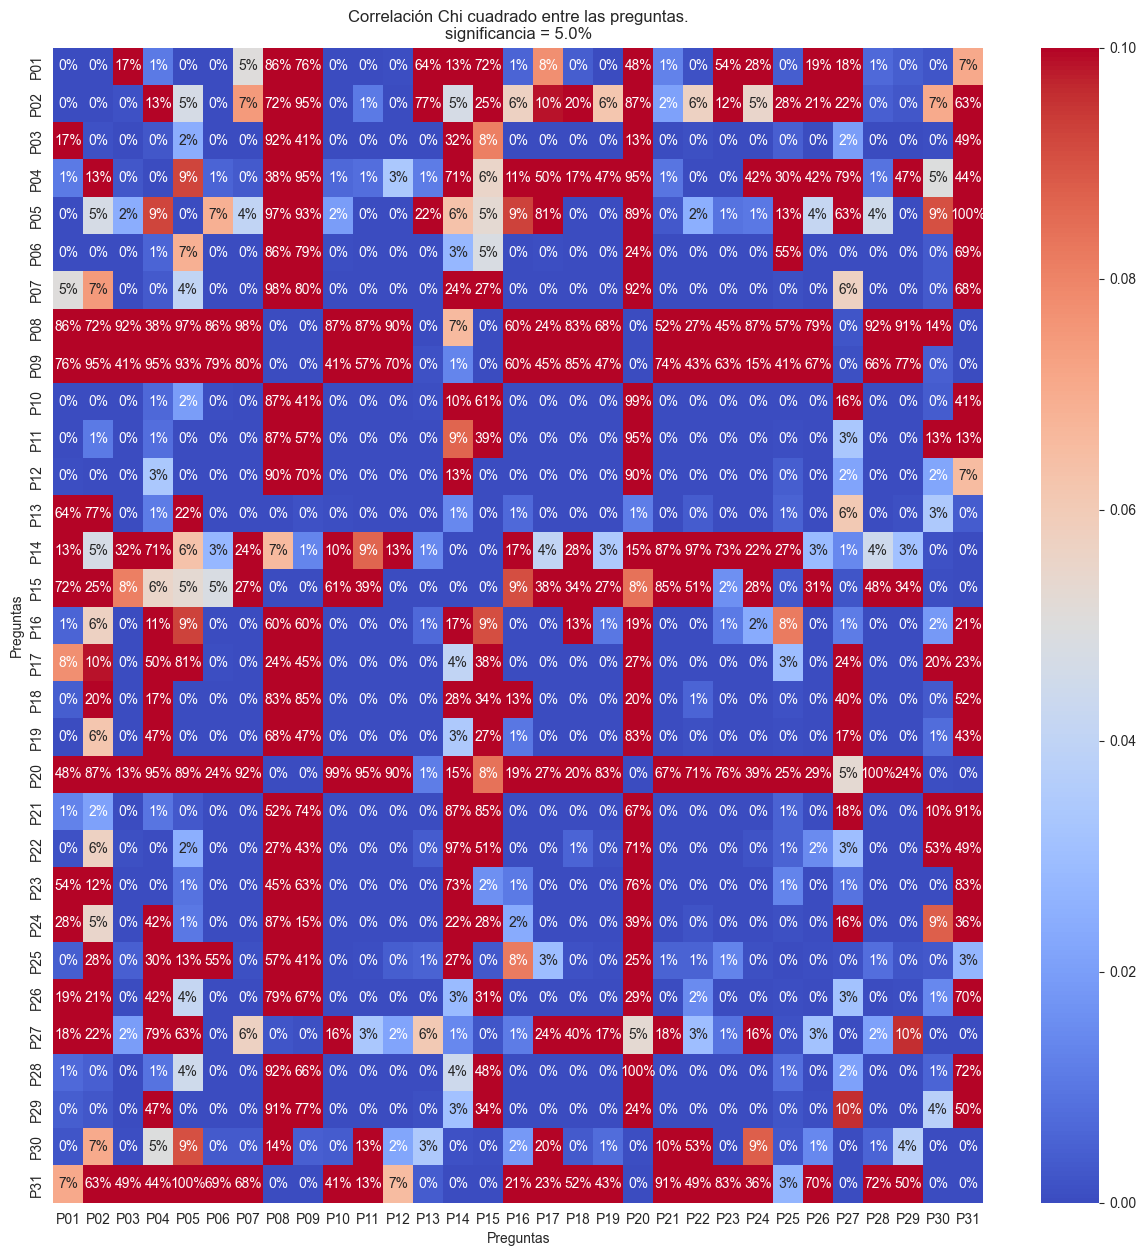

In [119]:
significancia = 0.05

fig, ax = plt.subplots(figsize=(15, 15))


sns.heatmap(
    chi_sqr_mat,
    vmin=0, vmax=significancia * 2,
    center=significancia,
    cmap="coolwarm",
    annot=True,
    fmt=".0%",
)

plt.title(f"Correlación Chi cuadrado entre las preguntas.\nsignificancia = {significancia:.1%}")

plt.ylabel("Preguntas")
plt.xlabel("Preguntas")

save_config = dict()
save_config.setdefault("dpi", 600)
save_config.setdefault("bbox_inches", "tight")
log.debug(f"{save_config=}")
fig.savefig(IMG_CORR_PATH / "corr-pregunta-pregunta-completo.png", **save_config)

plt.show()

**NO VERLO COMO VERDAD ABSOLUTA**

En un principio, interpreté que si dos preguntas estaba correlacionadas, entonces hay "información repetida", y una de las preguntas está "sobrando". Sin embargo, observando más detenidamente, me di cuenta que la pregunta 1 está correlacionada con la pregunta 2, y a su vez, la pregunta 2 está correlacionada con la pregunta 3, sin embargo, la pregunta 1 y 2 **no están correlacionadas**. Esto es algo extraño, pues si pensamos de la misma forma que al principio, uno esperaría una suerte de "transitividad".

Esto quiere decir que, las preguntas no eran tan "reemplazables" como uno esperaba al principio.

Anotar la palabra: *anticorrelación*